In [1]:
from brian2 import *
import numpy as np

In [2]:
# Define Rod_Kv
EKv_rev = -80*mV # Was -74mV
gKv_bar = 10*1e-3*msiemens*cm**-2

eqs_Kv = '''
IKv = gKv_bar * (m**4) * (V-EKv_rev) : amp / metre**2
dm/dt = (infmKv - m)/taumKv : 1

alphamKv = 0.005*(20-V/mV)/(exp((20-V/mV)/22)-1)/ms : Hz
betamKv = 1/15 * exp(-V/mV/80)/ms : Hz

taumKv = 1/(alphamKv+betamKv) : second
infmKv = alphamKv * taumKv : 1
'''

In [3]:
# Define Rod_ih
Eh_rev = -32*mV
Vhalf_h = -82*mV
gh_bar = 2.5*1e-3*msiemens*cm**-2
Sh = -5.33*mV
aoh = 1*Hz

eqs_h = '''
ah = 0.001*aoh*exp( (V-Vhalf_h)/(2*Sh) ) : Hz
bh = 0.001*aoh*exp( -(V-Vhalf_h)/(2*Sh) ) : Hz
tauh = 1/(ah+bh) : second
infh = ah*tauh : 1

dnh/dt = (infh-nh)/tauh : 1
gh = gh_bar * nh : siemens / metre**2
Ih = gh * (V-Eh_rev) : amp / metre**2
'''

In [4]:
# Define Rod_Kx
EKx_rev = -74*mV
gKx_bar = 1.04*msiemens*cm**-2
Vhalf_Kx = -49.9*mV
SKx = 5.7*mV
aoKx = 0.66*Hz

eqs_Kx = '''
aKx = 0.001*aoKx*exp( (V-Vhalf_Kx)/(2*SKx) ) : Hz
bKx = 0.001*aoKx*exp( -(V-Vhalf_Kx)/(2*SKx) ) : Hz
tauKx = 1/(aKx+bKx) : second
infKx = aKx*tauKx : 1

dnKx/dt = (infKx-nKx)/tauKx : 1

gKx = gKx_bar * (nKx**4) : siemens / metre**2
IKx = gKx * (V-EKx_rev) : amp / metre**2
'''

In [5]:
# Define Rod_leak
glbar = 0.52*msiemens*cm**-2
El_rev = -74*mV

eqs_leak = '''
Ileak = glbar * (V-El_rev) : amp / metre**2
'''

In [6]:
# Define Rod_Ca
gCabar = 4*1e-3*msiemens*cm**-2
ECa_rev = 40*mV
aomCa = 100*Hz
bomCa = 100*Hz
gammaohCa = 10*Hz
deltaohCa = 10*Hz

VhalfCam = -10*mV
VhalfCah = 11*mV

SCam = 6*mV
SCah = 9*mV

eqs_Ca = '''
alphamCa = 0.001*aomCa*exp( (V-VhalfCam)/(2*SCam) ) : Hz
betamCa = 0.001*bomCa*exp( -(V-VhalfCam)/(2*SCam) ) : Hz
gammahCa = 0.001*gammaohCa*exp( (V-VhalfCah)/(2*SCah) ) : Hz
deltahCa = 0.001*deltaohCa*exp( -(V-VhalfCah)/(2*SCah) ) : Hz

taumCa = 1/(alphamCa+betamCa) : second
infmCa = alphamCa/(alphamCa+betamCa) : 1

tauhCa = 1/(gammahCa+deltahCa) : second
infhCa = deltahCa/(gammahCa+deltahCa) : 1

dmCa/dt = (infmCa-mCa)/taumCa : 1
dhCa/dt = (infhCa-hCa)/tauhCa : 1

gCa = gCabar * mCa * hCa : siemens / metre**2
ICa = gCa * (V-ECa_rev) : amp / metre**2
'''

In [7]:
# Rod calcium dynamics model

depth = 10*umeter # Depth of shell
taur = 20*ms # Rate of calcium removal
Cainf = 5e-5*mM
Cao = 2*mM
entryF = 1
FARADAY = 96485.33289 * coulomb / mole

# drive_channel =  - (10000) * iCa / (2 * FARADAY * depth)
# 	if (drive_channel <= 0.) { drive_channel = 0.  }   : cannot pump inward 
         
# 	:ca' = drive_channel + (cainf-ca)/taur
#         :Ca' = drive_channel/18 + (Cainf -Ca)/taur*7
# 	Ca' = entryF*drive_channel/2 + (Cainf-Ca)/taur
	
#         Cai = Ca
# 	Cao=2 :mM
eqs_Cadyn = '''

Cai = Ca :mM
Cao = 2*mM :mM
drive_channel =  - (10000) * ICa / (2 * FARADAY * depth) :mM/second

dCa/dt = entryF*drive_channel/2 + (Cainf-Ca)/taur :mM

'''

In [8]:
# Define rod calcium activated chloride channel
ECl_rev = -20*mV
gCl_bar = 1.3*1e-3*msiemens*cm**-2
Clh = 1.5*umolar

eqs_CaCl = '''
Cas = Cai*1000 :mM
mCl = 1/(  1+(Clh/Cas)**4 ) :1
gCl = gCl_bar * mCl :siemens / metre**2
ICl = gCl * (V-ECl_rev) :amp / metre**2
'''


In [9]:
# Define rod calcium activated potassium channel
EKCa_rev = -80*mV
gKCa_bar = 5*1e-3*msiemens*cm**-2
Cahalf = 0.32*umolar

eqs_KCa = '''
# Cas = Cai*1000 :mM
mKcaCa = 1/(1+(Cahalf/Cas)**4 ) :1
gKCa = gKCa_bar * mKcaCa**4 :siemens / metre**2
IKCa = gKCa * (V-EKCa_rev) :amp / metre**2
'''


In [15]:
# Photocurrent and total HH current

# Photocurrent parameters
Idark = -40*pA
Tau1 = 50*ms
Tau2 = 450*ms
Tau3 = 800*ms
RodB = 3800*ms

eqs_input = '''
# input photocurrent
# Ip = Idark + A*( (1-exp(-t/Tau1)) - (1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3))): amp
# Why 32 and 33??
Ip = Idark + A*( 32*(1-exp(-t/Tau1)) - 33*(1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))/33: amp
A : amp
'''

In [16]:
# Morphology params
# L=10/PI
# 	diam=10
# 	cm= 30 //pF
length = 10/np.pi*umeter
Diam = 10*umetre
# Cm = 30*pF*cm**-2
# Rm = 6000*ohm*cm**2
Cm = 1*uF*cm**-2
Ra = 200*ohm*cm

Text(0, 0.5, 'Photocurrent (pA)')

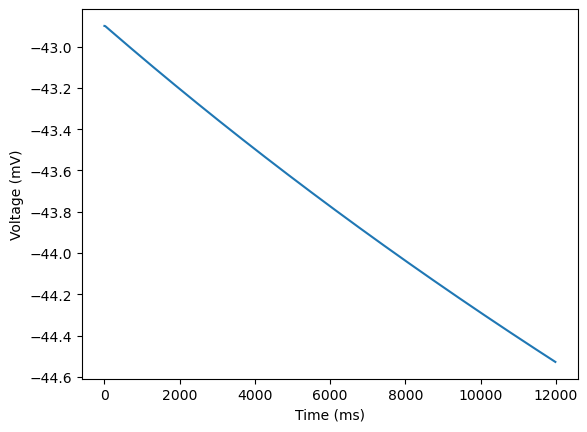

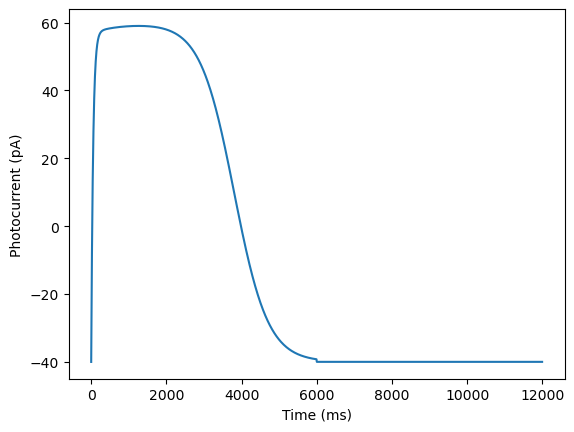

In [18]:
start_scope()
eqs_total = '''
# Transmembrane current
Im = 0*amp/metre**2 : amp / metre**2

#dV/dt = -(Ih + IKv + IKx + Ileak + ICa + ICl + IKCa + Ip/(metre**2) + Im) / Cm : volt
dV/dt = -(IKv + Ip/(metre**2) + Im) / Cm : volt
'''
eqs = eqs_input + eqs_total + eqs_Kv# + eqs_h + eqs_sum + eqs_Kx + eqs_leak + eqs_Ca + eqs_Cadyn + eqs_CaCl + eqs_KCa
morpho = Cylinder(diameter=Diam, n=1, length=8*umetre)
neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ra, method='euler')
# Monitor voltage and Ip
M = StateMonitor(neuron, 'V', record=True, dt=10*ms)
M2 = StateMonitor(neuron, 'Ip', record=True, dt=10*ms)
# neuron.Ca = Cainf
neuron.V = -42.9*mV
# neuron.A = 0*pA
# run(1000*ms)
neuron.A = 100*pA
run(6000*ms)
neuron.A = 0*pA
run(6000*ms)
plot(M.t/ms, M.V[0]/mV)
xlabel('Time (ms)')
ylabel('Voltage (mV)')
# ylim(-74, -73.8)

plt.figure()
plot(M2.t/ms, M2.Ip[0]/pA)
xlabel('Time (ms)')
ylabel('Photocurrent (pA)')

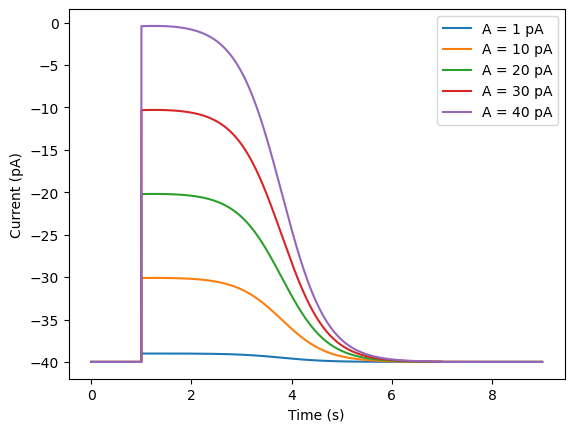

In [7]:
eqs = '''
# input photocurrent
# Ip = Idark + A*( (1-exp(-t/Tau1)) - (1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3))): amp
Ip = Idark + A*( 32*(1-exp(-t/Tau1)) - 33*(1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))/33: amp
A : amp
'''

# Simulate model in Brian2 with input A = 0.001nA
for input_amp in [1, 10, 20, 30, 40]:
    start_scope()
    G = NeuronGroup(1, eqs, method='euler')
    M = StateMonitor(G, 'Ip', record=True)
    G.A = 0*pA
    run(1000*ms)
    G.A = input_amp*pA
    run(6000*ms)
    G.A = 0*pA
    run(2000*ms)
    plot(M.t/second, M.Ip[0]/pA, label=f'A = {input_amp} pA')
    xlabel('Time (s)')
    ylabel('Current (pA)')
legend();